# Notebook for testing combining E/I method and Kent distribution for summarizing Cut Face data

In [1]:
import numpy as np
import pandas as pd

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib

import pymc3 as pm
from pymc3.distributions.continuous import Normal, Uniform, VonMises, Exponential
import theano.tensor as T
from theano.compile.ops import as_op
from pymc3.distributions import Continuous, draw_values, generate_samples

import arviz as az

import sys
sys.path.insert(0,'../../../Bayesian_PEP_inversion')

from bayesian_pep import *

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

import scipy.stats as st

%config InlineBackend.figure_format = 'retina'

In [2]:
d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6

## import data

In [3]:
Cutface_specimens = pd.read_csv('../../data/Pmag/cutface/specimens.txt', sep='\t', header=1)

Cutface_lat = 47.73055
Cutface_lon = -90.44128

Cutface_specimens['slat'] = Cutface_lat
Cutface_specimens['slon'] = Cutface_lon

In [4]:
specimens_mt_geo = Cutface_specimens[(Cutface_specimens['dir_comp']=='mt') & (Cutface_specimens['dir_tilt_correction']==0)]
specimens_mt_tc = Cutface_specimens[(Cutface_specimens['dir_comp']=='mt') & (Cutface_specimens['dir_tilt_correction']==100)]

specimens_ht_geo = Cutface_specimens[(Cutface_specimens['dir_comp']=='ht') & (Cutface_specimens['dir_tilt_correction']==0)]
specimens_ht_tc = Cutface_specimens[(Cutface_specimens['dir_comp']=='ht') & (Cutface_specimens['dir_tilt_correction']==100)]
specimens_ht_tc['plon'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[0]
specimens_ht_tc['plat'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[1]

In [5]:
# filter out the only negative inclination data
specimens_ht_tc=specimens_ht_tc[specimens_ht_tc['dir_inc']>0]

In [6]:
mean_mt = ipmag.fisher_mean(specimens_mt_tc['dir_dec'].tolist(),specimens_mt_tc['dir_inc'].tolist())
mean_ht = ipmag.fisher_mean(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist())

In [7]:
specimens_ht_tc.columns

Index(['specimen', 'experiments', 'sample', 'dir_alpha95', 'dir_comp',
       'dir_dec', 'dir_inc', 'dir_n_comps', 'dir_n_measurements',
       'dir_tilt_correction', 'dir_dang', 'dir_mad_free', 'meas_step_max',
       'meas_step_min', 'meas_step_unit', 'analysts', 'instrument_codes',
       'software_packages', 'int_corr', 'citations', 'method_codes',
       'result_quality', 'volume', 'weight', 'location', 'site',
       'specimen_name', 'slat', 'slon', 'plon', 'plat'],
      dtype='object')

## mt component directions

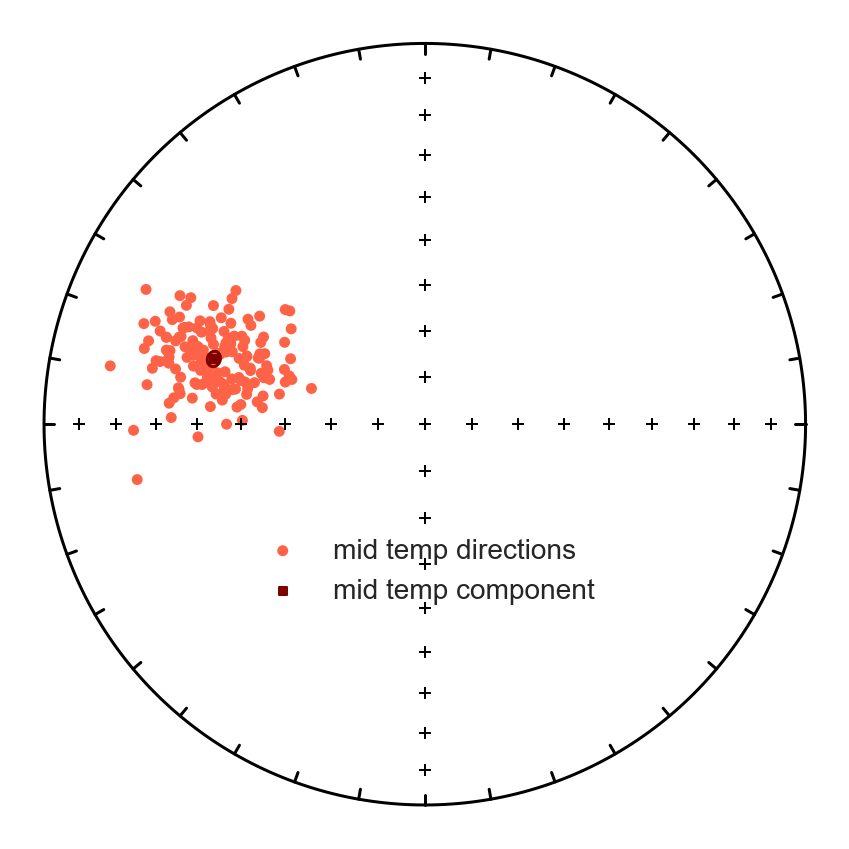

In [8]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(specimens_mt_tc['dir_dec'].tolist(),specimens_mt_tc['dir_inc'].tolist(),color='tomato',label='mid temp directions')

ipmag.plot_di_mean(mean_mt['dec'],mean_mt['inc'],mean_mt['alpha95'],
                    color='maroon', marker = 's', label='mid temp component')

plt.legend(loc=8,bbox_to_anchor=(0.50,0.25),fontsize=14)
plt.show()

## ht component directions

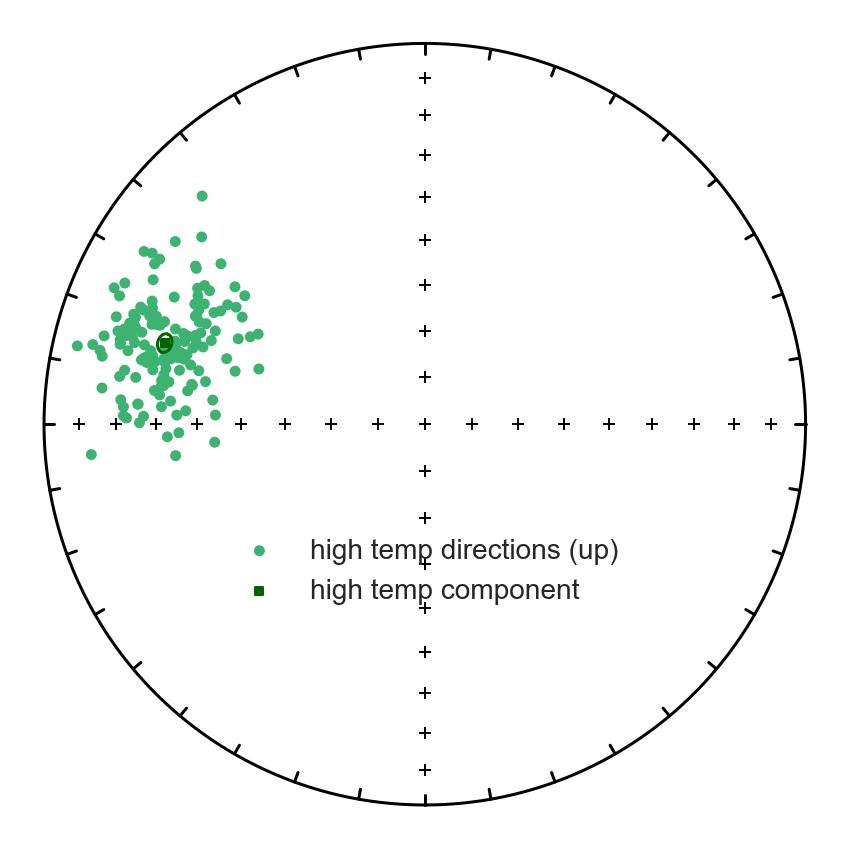

In [9]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist(),color='mediumseagreen',label='high temp directions (up)')

ipmag.plot_di_mean(mean_ht['dec'],mean_ht['inc'],mean_ht['alpha95'],
                   color='darkgreen', marker = 's', label='high temp component')

plt.legend(loc=8,bbox_to_anchor=(0.50,0.25),fontsize=14)
plt.show()

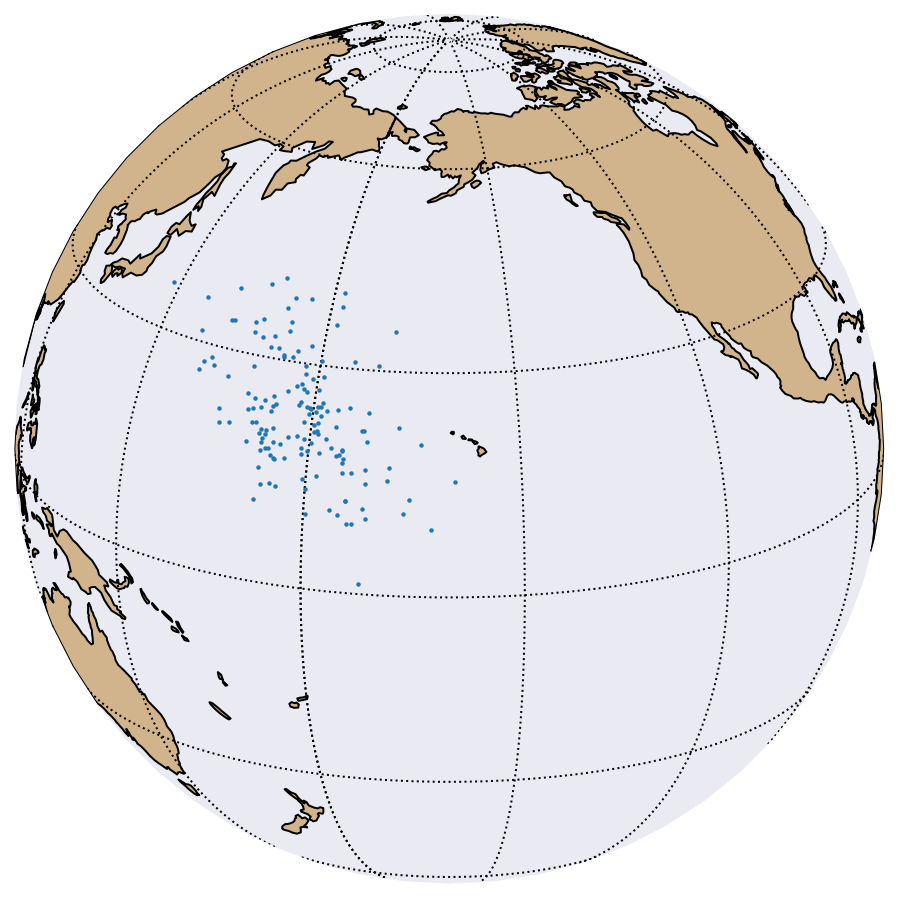

In [10]:
map_axis = ipmag.make_orthographic_map(200, 20)
ipmag.plot_vgp(map_axis, specimens_ht_tc['plon'].tolist(), specimens_ht_tc['plat'].tolist(), color='C0', markersize=5, edge='none')

## mt ht direction mean compared to NSVG direction mean

In [11]:
NSVG_pole_lat = 31.1 
NSVG_pole_lon = 181.7
NSVG_A95 = 4.2

NSVG_dec, NSVG_inc = pmag.vgp_di(NSVG_pole_lat,NSVG_pole_lon,Cutface_lat, Cutface_lon)

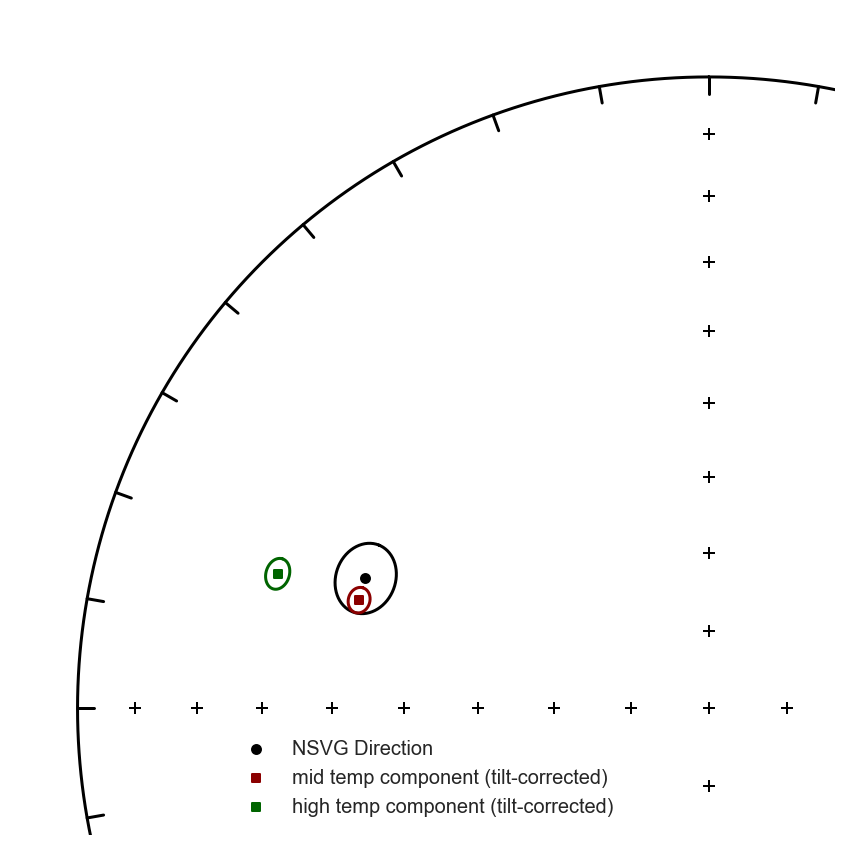

In [12]:
cf_igrf_nsvg_stereonet=plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di_mean(NSVG_dec, NSVG_inc, NSVG_A95, label='NSVG Direction') #need to replace with direction A95

ipmag.plot_di_mean(mean_mt['dec'],mean_mt['inc'],mean_mt['alpha95'],
                   color='darkred', marker = 's', label='mid temp component (tilt-corrected)')
ipmag.plot_di_mean(mean_ht['dec'],mean_ht['inc'],mean_ht['alpha95'],
                   color='darkgreen', marker = 's', label='high temp component (tilt-corrected)')

plt.xlim(-.7, -0.2)
plt.ylim(-0.2,1.1)
plt.legend(loc=8)
plt.show()

In [13]:
def find_ei(data, nb=1000, save=False, save_folder='.', fmt='svg',
            site_correction=False, return_new_dirs=False, figprefix='EI'):
    """
    Applies series of assumed flattening factor and "unsquishes" inclinations assuming tangent function.
    Finds flattening factor that gives elongation/inclination pair consistent with TK03;
    or, if correcting by site instead of for study-level secular variation,
    finds flattening factor that minimizes elongation and most resembles a
    Fisherian distribution.
    Finds bootstrap confidence bounds

    Required Parameter
    -----------
    data: a nested list of dec/inc pairs

    Optional Parameters (defaults are used unless specified)
    -----------
    nb: number of bootstrapped pseudo-samples (default is 1000)
    save: Boolean argument to save plots (default is False)
    save_folder: path to folder in which plots should be saved (default is current directory)
    fmt: specify format of saved plots (default is 'svg')
    figfile : name of saved file plus format string
    site_correction: Boolean argument to specify whether to "unsquish" data to
        1) the elongation/inclination pair consistent with TK03 secular variation model
        (site_correction = False)
        or
        2) a Fisherian distribution (site_correction = True). Default is FALSE.
        Note that many directions (~ 100) are needed for this correction to be reliable.
    return_new_dirs: optional return of newly "unflattened" directions (default is False)

    Returns
    -----------
    four plots:   1) equal area plot of original directions
                  2) Elongation/inclination pairs as a function of f,  data plus 25 bootstrap samples
                  3) Cumulative distribution of bootstrapped optimal inclinations plus uncertainties.
                     Estimate from original data set plotted as solid line
                  4) Orientation of principle direction through unflattening

    NOTE: If distribution does not have a solution, plot labeled: Pathological.  Some bootstrap samples may have
       valid solutions and those are plotted in the CDFs and E/I plot.
    """
    print("Bootstrapping.... be patient")
    print("")
    sys.stdout.flush()

    upper, lower = int(round(.975 * nb)), int(round(.025 * nb))
    E, I = [], []

    plt.figure(num=1, figsize=(4, 4))
    ipmag.plot_net(1)
    ipmag.plot_di(di_block=data)
    plt.title('Original')
    if save:
        plt.savefig(save_folder+'/'+figprefix+'_original_directions'+'.'+fmt)

    ppars = pmag.doprinc(data)
    Io = ppars['inc']
    n = ppars["N"]
    Es, Is, Fs, V2s = pmag.find_f(data)
    if site_correction == True:
        Inc, Elong = Is[Es.index(min(Es))], Es[Es.index(min(Es))]
        flat_f = Fs[Es.index(min(Es))]
    else:
        Inc, Elong = Is[-1], Es[-1]
        flat_f = Fs[-1]

    plt.figure(num=2, figsize=(4, 4))
    plt.plot(Is, Es, 'r')
    plt.xlabel("Inclination")
    plt.ylabel("Elongation")
    plt.text(Inc, Elong, ' %4.2f' % (flat_f))
    plt.text(Is[0] - 2, Es[0], ' %s' % ('f=1'))

    b = 0

    while b < nb:
        bdata = pmag.pseudo(data)
        Esb, Isb, Fsb, V2sb = pmag.find_f(bdata)
        if b < 25:
            plt.plot(Isb, Esb, 'y')
        if Esb[-1] != 0:
            ppars = pmag.doprinc(bdata)
            if site_correction == True:
                I.append(abs(Isb[Esb.index(min(Esb))]))
                E.append(Esb[Esb.index(min(Esb))])
            else:
                I.append(abs(Isb[-1]))
                E.append(Esb[-1])
            b += 1

    I.sort()
    E.sort()
    Eexp = []
    for i in I:
        Eexp.append(pmag.EI(i))
    plt.plot(I, Eexp, 'g-')
    if Inc == 0:
        title = 'Pathological Distribution: ' + \
            '[%7.1f, %7.1f]' % (I[lower], I[upper])
    else:
        title = '%7.1f [%7.1f, %7.1f]' % (Inc, I[lower], I[upper])
    if save:
        plt.savefig(save_folder+'/'+figprefix+'_EI_bootstraps'+'.'+fmt)

    cdf_fig_num = 3
    plt.figure(num=cdf_fig_num, figsize=(4, 4))
    pmagplotlib.plot_cdf(cdf_fig_num, I, 'Inclinations', 'r', title)
    pmagplotlib.plot_vs(cdf_fig_num, [I[lower], I[upper]], 'b', '--')
    pmagplotlib.plot_vs(cdf_fig_num, [Inc], 'g', '-')
    pmagplotlib.plot_vs(cdf_fig_num, [Io], 'k', '-')
    if save:
        plt.savefig(save_folder+'/'+figprefix+'_inc_CDF'+'.'+fmt)

    # plot corrected directional data

    di_lists = ipmag.unpack_di_block(data)
    if len(di_lists) == 3:
        decs, incs, intensity = di_lists
    if len(di_lists) == 2:
        decs, incs = di_lists
    if flat_f:
        unsquished_incs = ipmag.unsquish(incs, flat_f)
        plt.figure(num=4, figsize=(4, 4))
        ipmag.plot_net(4)
        ipmag.plot_di(decs, unsquished_incs)
        plt.title('Corrected for flattening')
    else:
        plt.figure(num=4, figsize=(4, 4))
        vplot_net(4)
        ipmag.plot_di(decs, incs)
        plt.title('Corrected for flattening')
    if save:
        plt.savefig(save_folder+'/'+figprefix+'_corrected_directions'+'.'+fmt)

    if (Inc, Elong, flat_f) == (0, 0, 0):
        print("PATHOLOGICAL DISTRIBUTION")
    print("The original inclination was: " + str(np.round(Io,2)))
    print("")
    print("The corrected inclination is: " + str(np.round(Inc,2)))
    print("with bootstrapped confidence bounds of: " +
          str(np.round(I[lower],2)) + ' to ' + str(np.round(I[upper],2)))
    print("and elongation parameter of: " + str(np.round(Elong,2)))
    print("The flattening factor is: " + str(np.round(flat_f,2)))
    f_lower = np.tan(np.deg2rad(Io))/np.tan(np.deg2rad(I[lower]))
    f_upper = np.tan(np.deg2rad(Io))/np.tan(np.deg2rad(I[upper]))
    print("with bootstrapped confidence bounds of: " +
           str(np.round(f_lower,2)) + ' to ' + str(np.round(f_upper,2)))
    
    F = np.tan(np.deg2rad(Io))/np.tan(np.deg2rad(I))
    return I, E, F


Bootstrapping.... be patient

The original inclination was: 29.21

The corrected inclination is: 40.11
with bootstrapped confidence bounds of: 33.95 to 45.54
and elongation parameter of: 1.96
The flattening factor is: 0.65
with bootstrapped confidence bounds of: 0.83 to 0.55


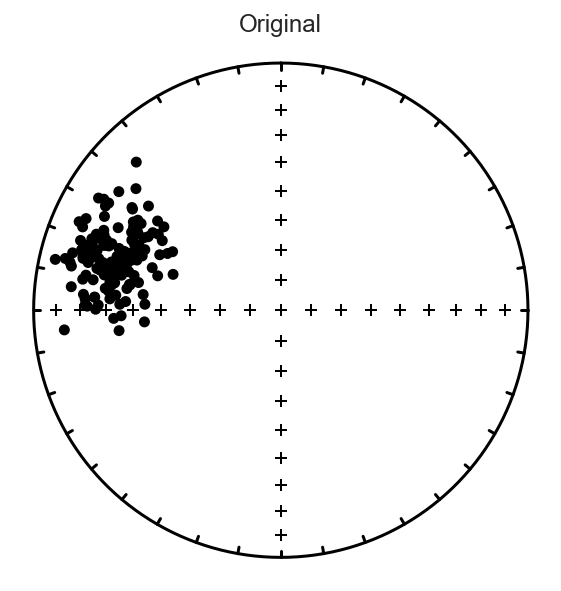

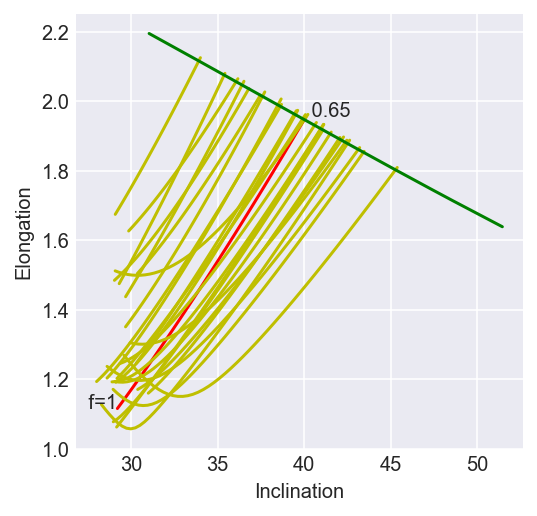

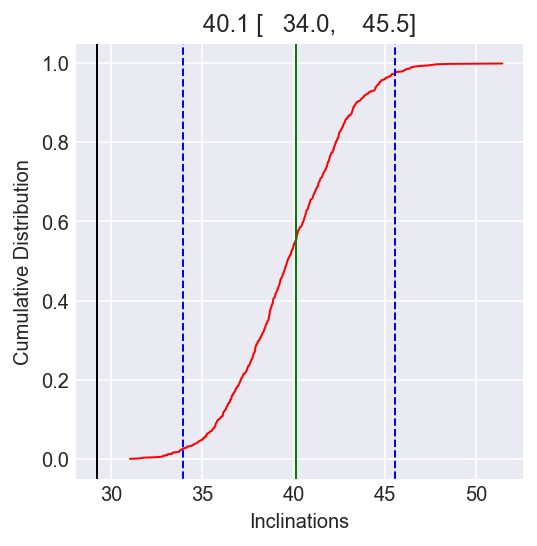

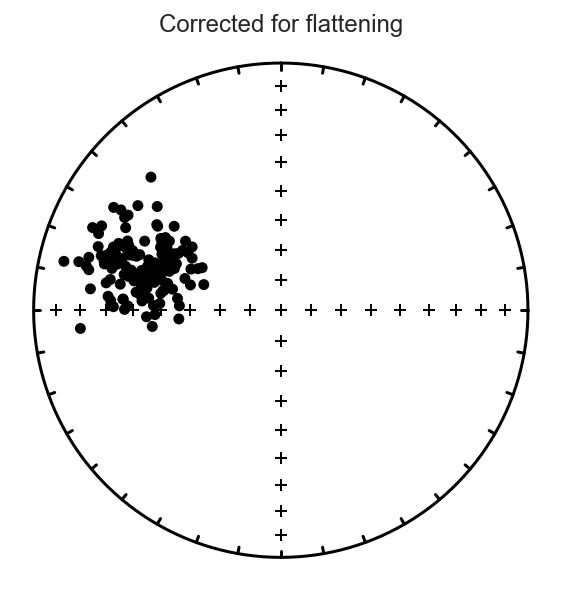

In [14]:
I, E, F = find_ei(specimens_ht_tc[['dir_dec', 'dir_inc']].to_numpy(), return_new_dirs = 1)

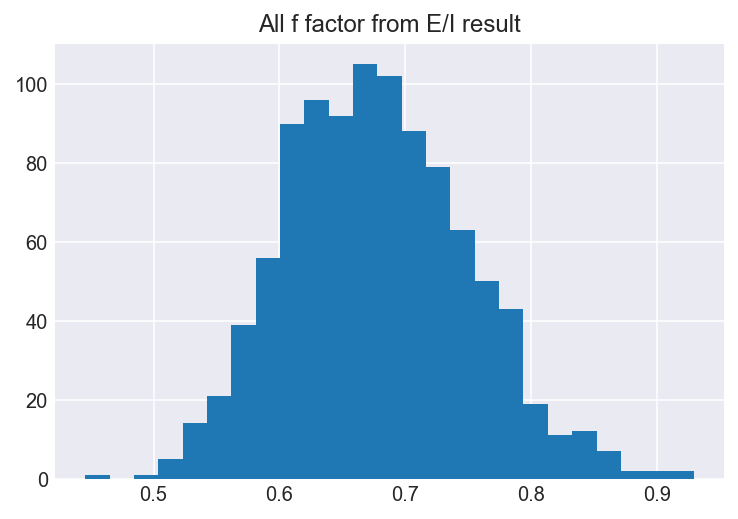

In [15]:
plt.hist(F, bins=25)
plt.title('All f factor from E/I result');

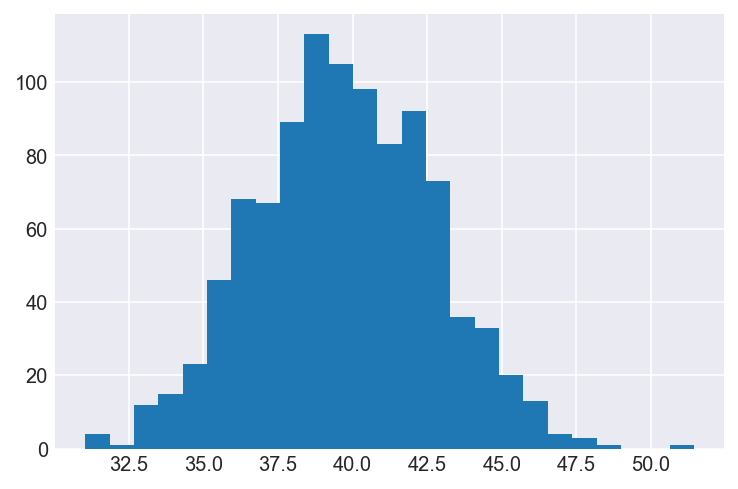

In [16]:
plt.hist(I, bins=25);

### show all unsquished directions according to E/I bootstrap results

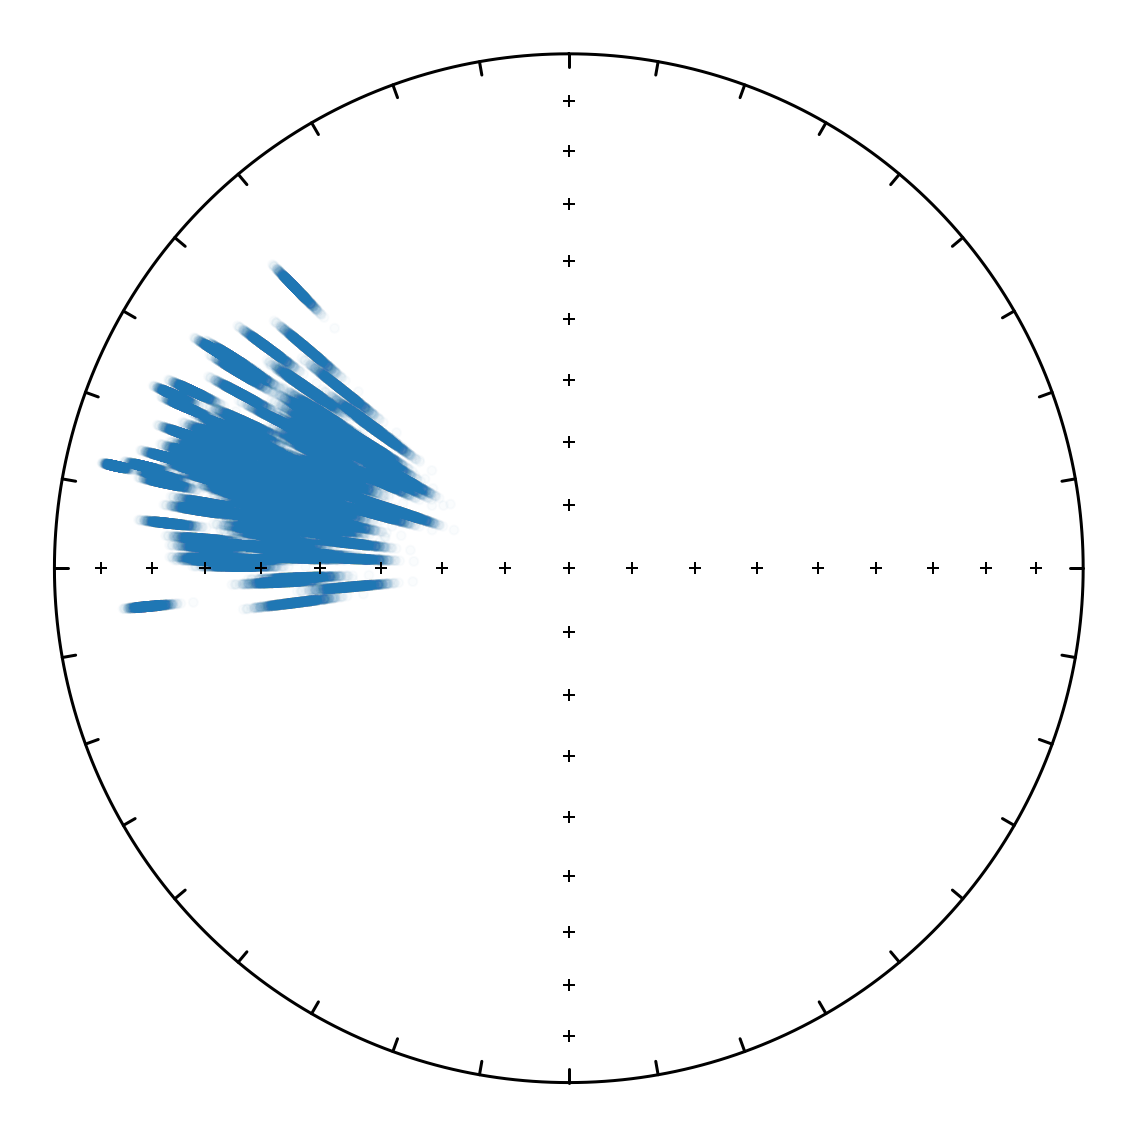

In [17]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()

plt.figure(figsize=(8,8))
ipmag.plot_net()
for f in F:
    these_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    ipmag.plot_di(specimens_ht_tc_decs, these_incs, color = 'C0', alpha=0.02)
    
    
    
# unsquish_df = specimens_ht_tc[['dir_dec', dir_inc, slon, slat, plon, plat]]



<Figure size 576x576 with 0 Axes>

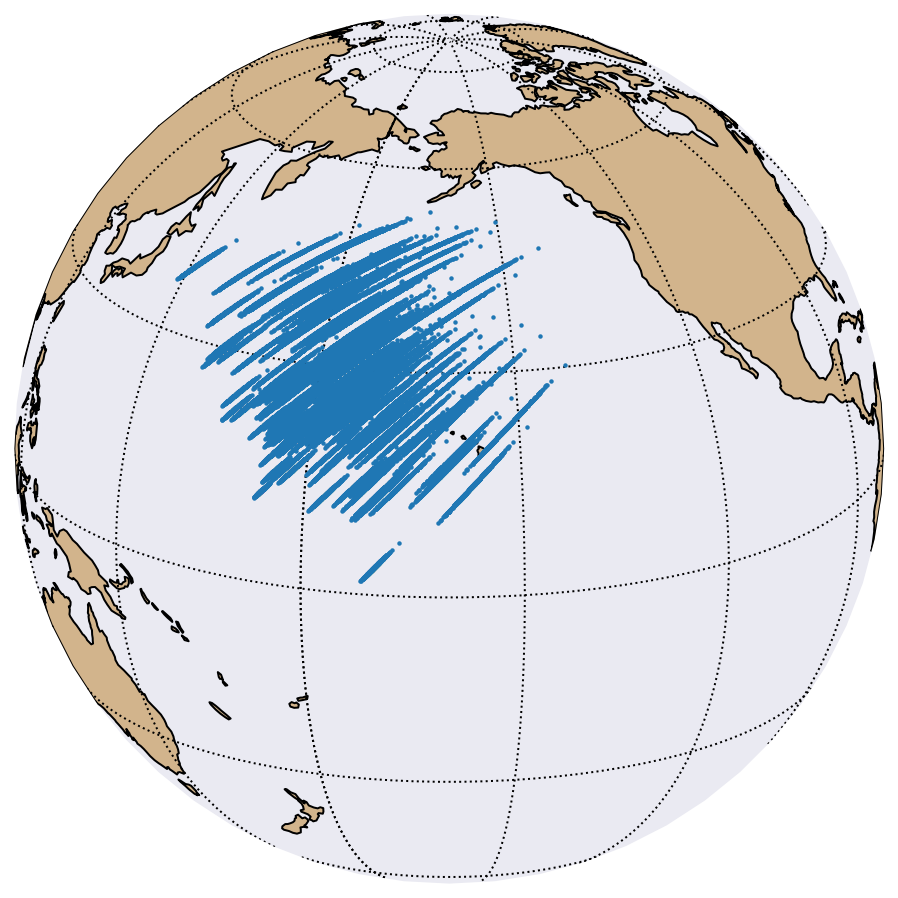

In [18]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
for f in F:
    these_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    these_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, these_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    these_lons, these_lats = these_VGPs[0], these_VGPs[1]
    ipmag.plot_vgp(m, these_lons, these_lats, color = 'C0', edge='none', markersize=5)
    
    
    
# unsquish_df = specimens_ht_tc[['dir_dec', dir_inc, slon, slat, plon, plat]]



<Figure size 576x576 with 0 Axes>

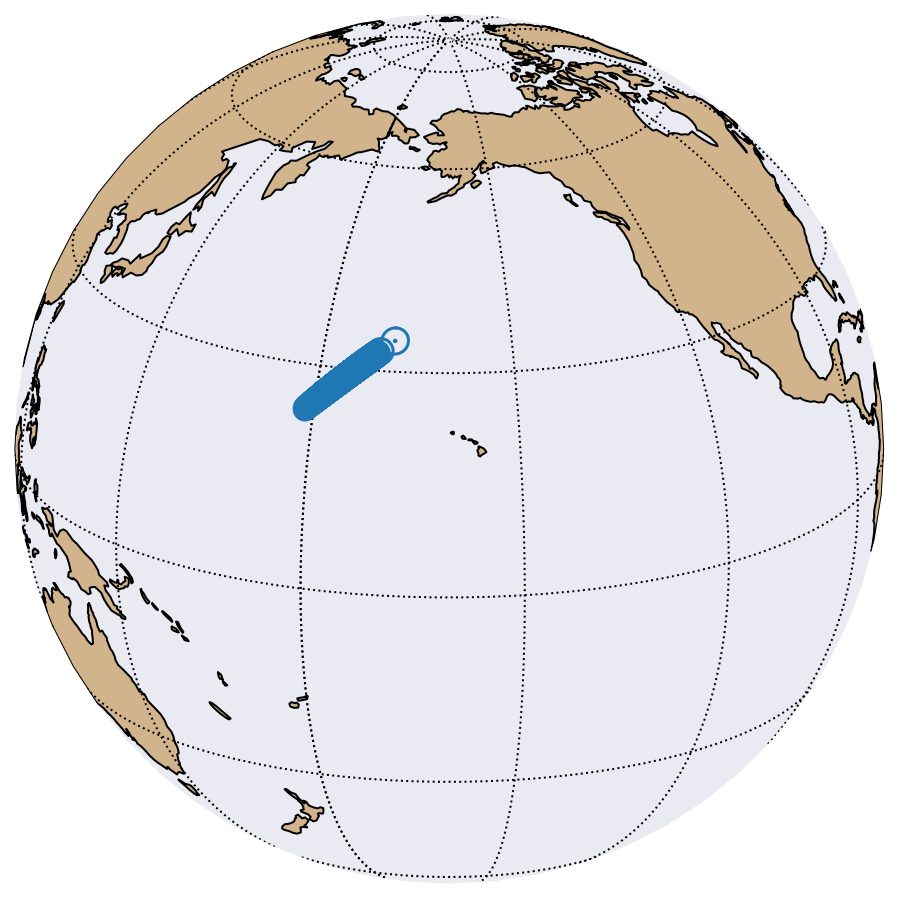

In [19]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
for f in F:
    these_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    these_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, these_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    these_lons, these_lats = these_VGPs[0], these_VGPs[1]
    these_VGPs_mean = ipmag.fisher_mean(these_lons, these_lats)
#     ipmag.plot_vgp(m, these_lons, these_lats, color = 'C0', edge='none', markersize=5)
    ipmag.plot_pole(m, these_VGPs_mean['dec'], these_VGPs_mean['inc'], these_VGPs_mean['alpha95'], color='C0', edgecolor='none', markersize=5)
    
    
# unsquish_df = specimens_ht_tc[['dir_dec', dir_inc, slon, slat, plon, plat]]



<Figure size 576x576 with 0 Axes>

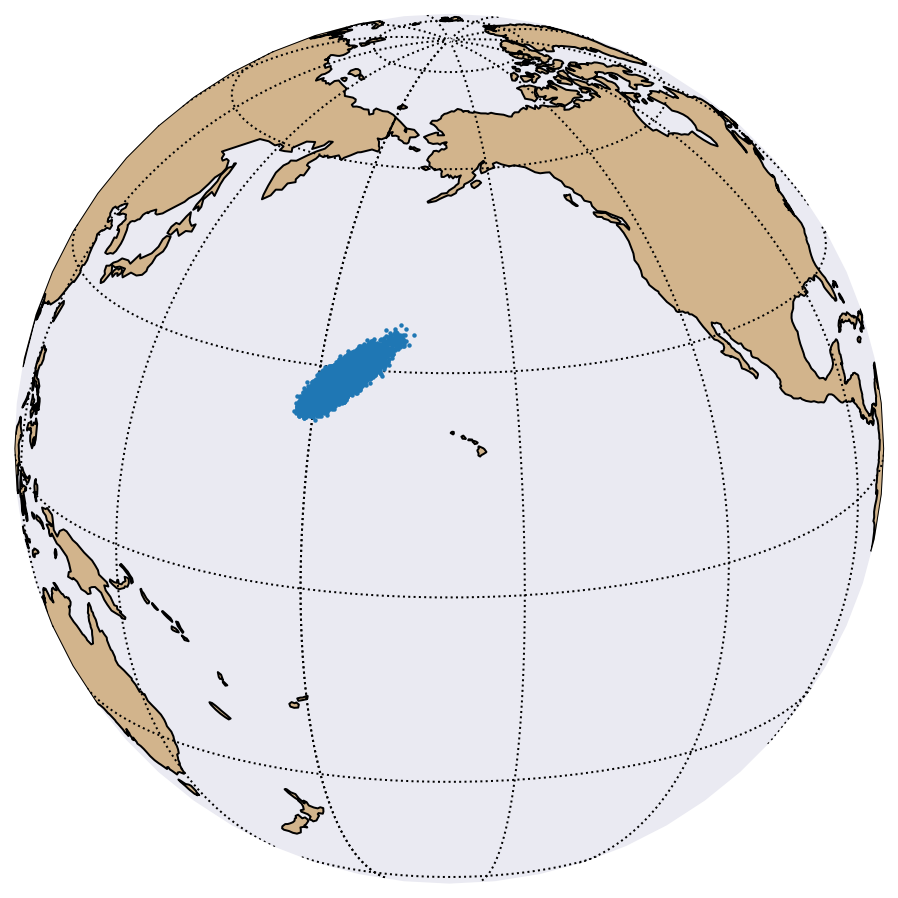

In [20]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

kent_lons = []
kent_lats = []

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
for f in F:
    these_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    these_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, these_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    these_lons, these_lats = these_VGPs[0], these_VGPs[1]
    these_VGPs_mean = ipmag.fisher_mean(these_lons, these_lats)
#     print(these_VGPs_mean)
    resampled_lons, resampled_lats = ipmag.fishrot(k=kappa_from_two_sigma(these_VGPs_mean['alpha95']), n=100, dec=these_VGPs_mean['dec'], inc=these_VGPs_mean['inc'], di_block=0)
    kent_lons.extend(resampled_lons)
    kent_lats.extend(resampled_lats)
    ipmag.plot_vgp(m, resampled_lons, resampled_lats, color='C0', edge='none', markersize=5)
        
# unsquish_df = specimens_ht_tc[['dir_dec', dir_inc, slon, slat, plon, plat]]

In [54]:
def bin_trace(lon_samples, lat_samples, resolution):
    """
    Given a trace of samples in longitude and latitude, bin them
    in latitude and longitude, and normalize the bins so that
    the integral of probability density over the sphere is one.

    The resolution keyword gives the number of divisions in latitude.
    The divisions in longitude is twice that.
    """
    lats = np.linspace(-90., 90., resolution, endpoint=True)
    lons = np.linspace(-180., 180., 2 * resolution, endpoint=True)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    hist = np.zeros_like(lon_grid)

    dlon = 360. / (2. * resolution)
    dlat = 180. / resolution

    for lon, lat in zip(lon_samples, lat_samples):

        lon = np.mod(lon, 360.)
        if lon > 180.:
            lon = lon - 360.
        if lat < -90. or lat > 90.:
            # Just skip invalid latitudes if they happen to arise
            continue

        lon_index = int(np.floor((lon + 180.) / dlon))
        lat_index = int(np.floor((lat + 90.) / dlat))
        hist[lat_index, lon_index] += 1

    lat_grid += dlat / 2.
    lon_grid += dlon / 2.
    return lon_grid, lat_grid, hist


def density_distribution(lon_samples, lat_samples, resolution=30):
    count = len(lon_samples)
    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)
    return lon_grid, lat_grid, hist / count


def cumulative_density_distribution(lon_samples, lat_samples, resolution=30):

    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)

    # Compute the cumulative density
    hist = hist.ravel()
    i_sort = np.argsort(hist)[::-1]
    i_unsort = np.argsort(i_sort)
    hist_cumsum = hist[i_sort].cumsum()
    hist_cumsum /= hist_cumsum[-1]

    return lon_grid, lat_grid, hist_cumsum[i_unsort].reshape(lat_grid.shape)


def plot_distributions(ax, lon_samples, lat_samples, to_plot='d', resolution=100, **kwargs):

    cmap=kwargs.get('cmap', 'viridis')

    artists = []

    if 'd' in to_plot:
        lon_grid, lat_grid, density = density_distribution(
            lon_samples, lat_samples, resolution)
        density = ma.masked_where(density <= 0.05*density.max(), density)
        a = ax.pcolormesh(lon_grid, lat_grid, density, cmap=cmap,
                          transform=ccrs.PlateCarree())
        artists.append(a)

    if 'e' in to_plot:
        lon_grid, lat_grid, cumulative_density = cumulative_density_distribution(
            lon_samples, lat_samples, resolution)
        a = ax.contour(lon_grid, lat_grid, cumulative_density, levels=[
                       0.025, 0.975], cmap=cmap, transform=ccrs.PlateCarree(), lw=kwargs.get('lw', 1))
        artists.append(a)

    if 's' in to_plot:
        a = ax.scatter(lon_samples, lat_samples, color=kwargs.get('color', 'C0'), alpha=0.1, transform=ccrs.PlateCarree(), edgecolors=None, **kwargs)
        artists.append(a)

    return artists

<Figure size 576x576 with 0 Axes>

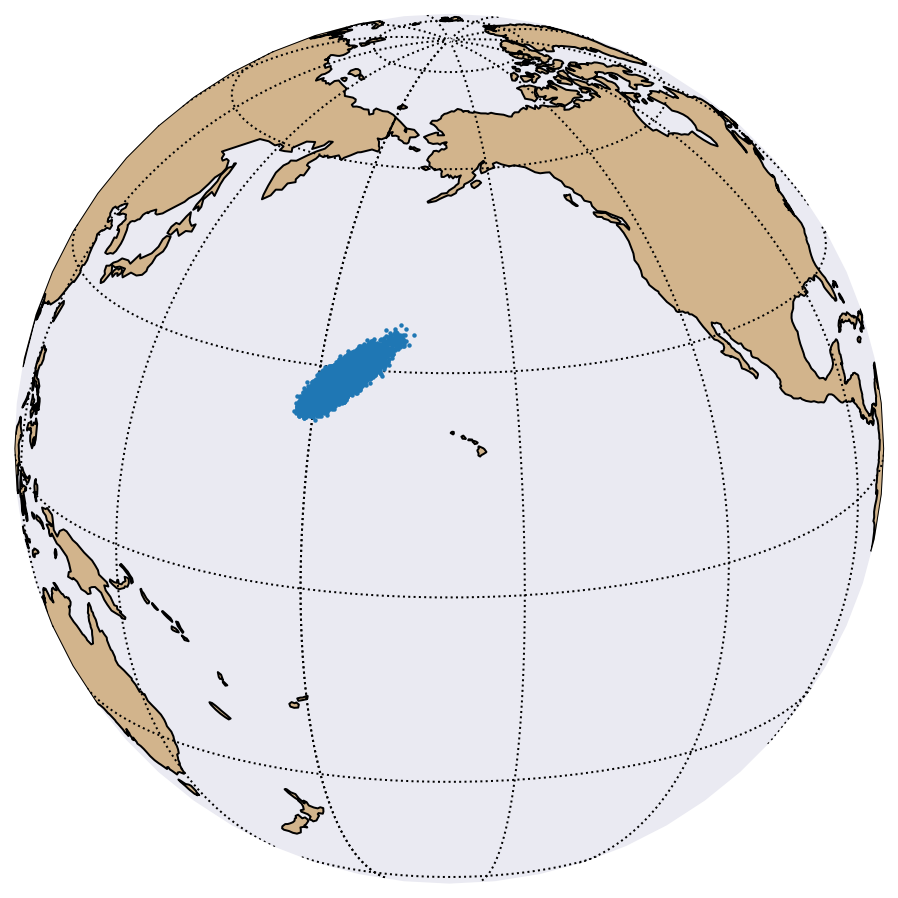

In [22]:
plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_vgp(m, kent_lons, kent_lats, color='C0', edge='none', markersize=5)

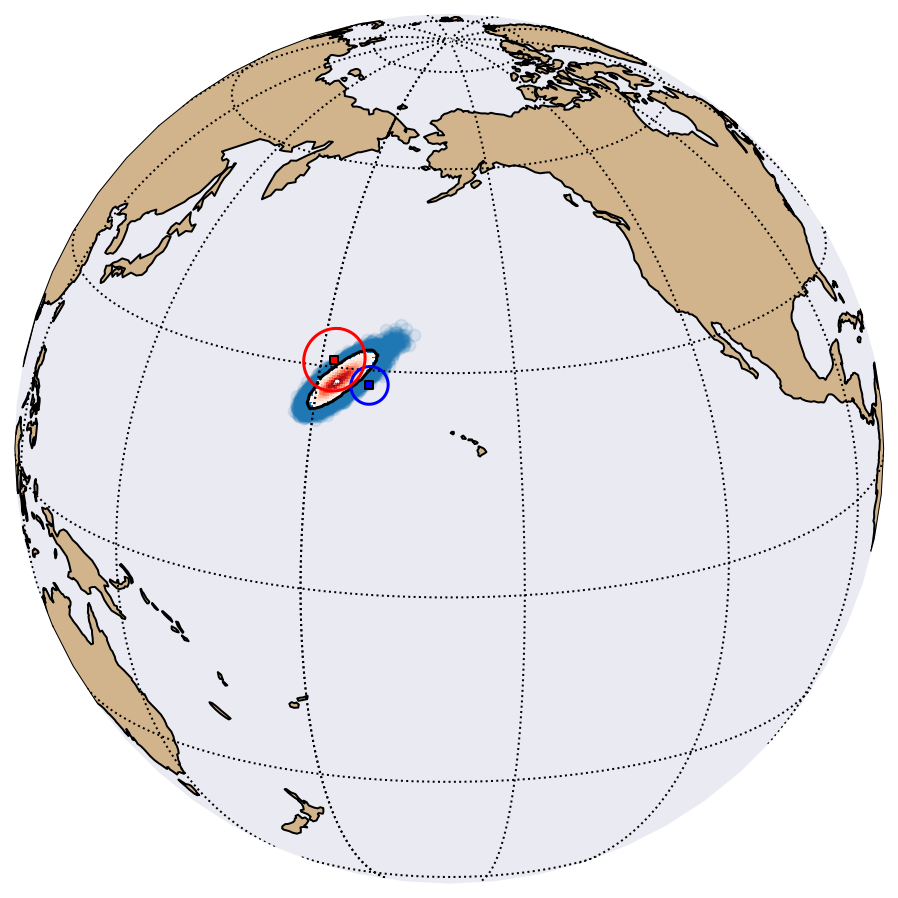

In [23]:
# plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_pole(m,188,28,2.5,label='Schroeder Lutsen Basalts', marker='s',color='Blue')
ipmag.plot_pole(m,182,31,4.2,label='North Shore Volcanic Group (upper NE)',marker='s',color='Red')
plot_distributions(m, kent_lons, kent_lats, to_plot='s', resolution = 500)
plot_distributions(m, kent_lons, kent_lats, to_plot='d', resolution = 500, cmap='Reds')
plot_distributions(m, kent_lons, kent_lats, to_plot='e', resolution = 500, cmap='Greys')
# m.legend()

## Use E/I result and a Kent distribution

Say we take the frequentist's path. Let's first bootstrap f factor from E/I result, then correct for inclinations and calcualte VGPs and try to use Kent to summarize the result.

In [56]:
def dokent_95(data):
    """
    gets Kent  parameters for data
    Parameters
    ___________________
    data :  nested pairs of [Dec,Inc]
    NN  : normalization
        NN is the number of data for Kent ellipse
        NN is 1 for Kent ellipses of bootstrapped mean directions

    Return
    kpars dictionary keys
        dec : mean declination
        inc : mean inclination
        n : number of datapoints
        Eta : major ellipse
        Edec : declination of major ellipse axis
        Einc : inclination of major ellipse axis
        Zeta : minor ellipse
        Zdec : declination of minor ellipse axis
        Zinc : inclination of minor ellipse axis
    """
    X, kpars = [], {}
    N = len(data)
    if N < 2:
        return kpars
#
#  get fisher mean and convert to co-inclination (theta)/dec (phi) in radians
#
    fpars = fisher_mean(data)
    pbar = fpars["dec"] * np.pi / 180.
    tbar = (90. - fpars["inc"]) * np.pi / 180.
#
#   initialize matrices
#
    H = [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]
    w = [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]
    b = [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]
    gam = [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]
    xg = []
#
#  set up rotation matrix H
#
    H = [[np.cos(tbar) * np.cos(pbar), -np.sin(pbar), np.sin(tbar) * np.cos(pbar)], [np.cos(tbar)
                                                                                     * np.sin(pbar), np.cos(pbar), np.sin(pbar) * np.sin(tbar)], [-np.sin(tbar), 0., np.cos(tbar)]]
#
#  get cartesian coordinates of data
#
    for rec in data:
        X.append(dir2cart([rec[0], rec[1], 1.]))
#
#   put in T matrix
#
    T = Tmatrix(X)
    for i in range(3):
        for j in range(3):
            T[i][j] = old_div(T[i][j], float(N))
#
# compute B=H'TH
#
    for i in range(3):
        for j in range(3):
            for k in range(3):
                w[i][j] += T[i][k] * H[k][j]
    for i in range(3):
        for j in range(3):
            for k in range(3):
                b[i][j] += H[k][i] * w[k][j]
#
# choose a rotation w about North pole to diagonalize upper part of B
#
    psi = 0.5 * np.arctan(2. * b[0][1] / (b[0][0] - b[1][1]))
    w = [[np.cos(psi), -np.sin(psi), 0],
         [np.sin(psi), np.cos(psi), 0], [0., 0., 1.]]
    for i in range(3):
        for j in range(3):
            gamtmp = 0.
            for k in range(3):
                gamtmp += H[i][k] * w[k][j]
            gam[i][j] = gamtmp
    for i in range(N):
        xg.append([0., 0., 0.])
        for k in range(3):
            xgtmp = 0.
            for j in range(3):
                xgtmp += gam[j][k] * X[i][j]
            xg[i][k] = xgtmp
# compute asymptotic ellipse parameters
#
    xmu, sigma1, sigma2 = 0., 0., 0.
    for i in range(N):
        xmu += xg[i][2]
        sigma1 = sigma1 + xg[i][0]**2
        sigma2 = sigma2 + xg[i][1]**2
    xmu = old_div(xmu, float(N))
    sigma1 = old_div(sigma1, float(N))
    sigma2 = old_div(sigma2, float(N))
    g = -2.0 * np.log(0.05) / (xmu**2)
    if np.sqrt(sigma1 * g) < 1:
        eta = np.arcsin(np.sqrt(sigma1 * g))
    if np.sqrt(sigma2 * g) < 1:
        zeta = np.arcsin(np.sqrt(sigma2 * g))
    if np.sqrt(sigma1 * g) >= 1.:
        eta = old_div(np.pi, 2.)
    if np.sqrt(sigma2 * g) >= 1.:
        zeta = old_div(np.pi, 2.)
#
#  convert Kent parameters to directions,angles
#
    kpars["dec"] = fpars["dec"]
    kpars["inc"] = fpars["inc"]
    kpars["n"] = N
    ZDir = cart2dir([gam[0][1], gam[1][1], gam[2][1]])
    EDir = cart2dir([gam[0][0], gam[1][0], gam[2][0]])
    kpars["Zdec"] = ZDir[0]
    kpars["Zinc"] = ZDir[1]
    kpars["Edec"] = EDir[0]
    kpars["Einc"] = EDir[1]
    if kpars["Zinc"] < 0:
        kpars["Zinc"] = -kpars["Zinc"]
        kpars["Zdec"] = (kpars["Zdec"] + 180.) % 360.
    if kpars["Einc"] < 0:
        kpars["Einc"] = -kpars["Einc"]
        kpars["Edec"] = (kpars["Edec"] + 180.) % 360.
    kpars["Zeta"] = zeta * 180. / np.pi
    kpars["Eta"] = eta * 180. / np.pi
    return kpars

In [24]:
kent_blocks = np.array([kent_lons, kent_lats]).T

kent_fits = pmag.dokent(kent_blocks, kent_blocks.shape[0])

In [25]:
kent_fits

{'dec': 183.34614366797123,
 'inc': 28.168283710956203,
 'n': 100000,
 'Zdec': 297.2311899999861,
 'Zinc': 37.09458820809549,
 'Edec': 66.63327295666744,
 'Einc': 40.012320032093434,
 'Zeta': 0.01711362893901443,
 'Eta': 0.005232707421921746}

In [52]:
kent_fits_95 = dokent_95(kent_blocks)

In [53]:
kent_fits_95

{'dec': 183.34614366797123,
 'inc': 28.168283710956203,
 'n': 100000,
 'Zdec': 297.2311899999861,
 'Zinc': 37.09458820809549,
 'Edec': 66.63327295666744,
 'Einc': 40.012320032093434,
 'Zeta': 5.4198839679611375,
 'Eta': 1.6549574914668628}

In [28]:
kent_fits_modified = kent_fits

kent_fits_modified['Zeta'] = kent_fits_modified['Zeta']*np.sqrt(kent_fits_modified['n'])
kent_fits_modified['Eta'] = kent_fits_modified['Eta']*np.sqrt(kent_fits_modified['n'])

In [29]:
kent_fits_modified

{'dec': 183.34614366797123,
 'inc': 28.168283710956203,
 'n': 100000,
 'Zdec': 297.2311899999861,
 'Zinc': 37.09458820809549,
 'Edec': 66.63327295666744,
 'Einc': 40.012320032093434,
 'Zeta': 5.411804647825642,
 'Eta': 1.6547273782540415}

In [35]:
from pmagpy.pmag import*

def get_ell(fignum, pars, col):
    """
    function to calculate points on an ellipse about Pdec,Pdip with angle beta,gamma
    Parameters
    _________
    pars : list of [Pdec, Pinc, beta, Bdec, Binc, gamma, Gdec, Ginc ]
         where P is direction, Bdec,Binc are beta direction, and Gdec,Ginc are gamma direction
    col : color for ellipse
    lower : boolean, if True, lower hemisphere projection
    plot : boolean, if False, return the points, if False, make the plot
    """
    rad = old_div(np.pi, 180.)
    Pdec, Pinc, beta, Bdec, Binc, gamma, Gdec, Ginc = pars[0], pars[
        1], pars[2], pars[3], pars[4], pars[5], pars[6], pars[7]
    if beta > 90. or gamma > 90:
        beta = 180. - beta
        gamma = 180. - gamma
        Pdec = Pdec - 180.
        Pinc = -Pinc
    beta, gamma = beta * rad, gamma * rad  # convert to radians
    X_ell, Y_ell, X_up, Y_up, PTS = [], [], [], [], []
    nums = 201
    xnum = old_div(float(nums - 1.), 2.)
# set up t matrix
    t = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    X = pmag.dir2cart((Pdec, Pinc, 1.0))  # convert to cartesian coordintes
#     if lower == 1 and X[2] < 0:
#         for i in range(3):
#             X[i] = -X[i]
# set up rotation matrix t
    t[0][2] = X[0]
    t[1][2] = X[1]
    t[2][2] = X[2]
    X = pmag.dir2cart((Bdec, Binc, 1.0))
#     if lower == 1 and X[2] < 0:
#         for i in range(3):
#             X[i] = -X[i]
    t[0][0] = X[0]
    t[1][0] = X[1]
    t[2][0] = X[2]
    X = pmag.dir2cart((Gdec, Ginc, 1.0))
#     if lower == 1 and X[2] < 0:
#         for i in range(3):
#             X[i] = -X[i]
    t[0][1] = X[0]
    t[1][1] = X[1]
    t[2][1] = X[2]
# set up v matrix
    v = [0, 0, 0]
    for i in range(nums):  # incremental point along ellipse
        psi = float(i) * np.pi / xnum
        v[0] = np.sin(beta) * np.cos(psi)
        v[1] = np.sin(gamma) * np.sin(psi)
        v[2] = np.sqrt(1. - v[0]**2 - v[1]**2)
        elli = [0, 0, 0]
# calculate points on the ellipse
        for j in range(3):
            for k in range(3):
                # cartesian coordinate j of ellipse
                elli[j] = elli[j] + t[j][k] * v[k]
        pts = pmag.cart2dir(elli)
        PTS.append([pts[0], pts[1]])
        # put on an equal area projection
        R = old_div(np.sqrt(
            1. - abs(elli[2])), (np.sqrt(elli[0]**2 + elli[1]**2)))
        if elli[2] <= 0:
            #            for i in range(3): elli[i]=-elli[i]
            X_up.append(elli[1] * R)
            Y_up.append(elli[0] * R)
        else:
            X_ell.append(elli[1] * R)
            Y_ell.append(elli[0] * R)

    return PTS

In [46]:
def plot_pole_ellipse(map_axis, dictionary, 
                      color='k', edgecolor='k', marker='s', 
                      markersize=20, label='', alpha=1.0, lw=1):
    """
    Plot a mean direction (declination, inclination)  confidence ellipse.

    Parameters
    -----------
    map_axis : the name of the current map axis that has been developed using cartopy
    dictionary : a dictionary generated by the pmag.dobingham or pmag.dokent functions
    
    Optional Parameters (defaults are used if not specified)
    -----------
    color : symbol color; the default color is black. Other colors can be chosen (e.g. 'r')
    marker : the default marker is a circle. Other symbols can be chosen (e.g. 's')
    markersize : the default is 20. Other size can be chosen
    label : the default is no label. Labels can be assigned.
    legend : the default is no legend ('no'). Putting 'yes' will plot a legend.
    filled_pole : if True, the A95 ellipse will be filled with color
    fill_color : color of fill; the default is black.
    fill_alpha : transparency of filled ellipse (the default is 1.0; no transparency).
    """
    pars = []
    pars.append(dictionary['dec'])
    pars.append(dictionary['inc'])
    pars.append(dictionary['Zeta'])
    pars.append(dictionary['Zdec'])
    pars.append(dictionary['Zinc'])
    pars.append(dictionary['Eta'])
    pars.append(dictionary['Edec'])
    pars.append(dictionary['Einc'])

    map_axis.scatter(dictionary['dec'], dictionary['inc'], marker=marker,
                     color=color, edgecolors=edgecolor, s=markersize,
                     label=label, zorder=101, transform=ccrs.PlateCarree())

    ellipse_points = np.array(get_ell(fignum, pars, color)).T
    map_axis.plot(ellipse_points[0], ellipse_points[1], color=color,
                 transform=ccrs.Geodetic(), alpha=alpha, lw=lw)
    
    return map_axis


<GeoAxesSubplot:>

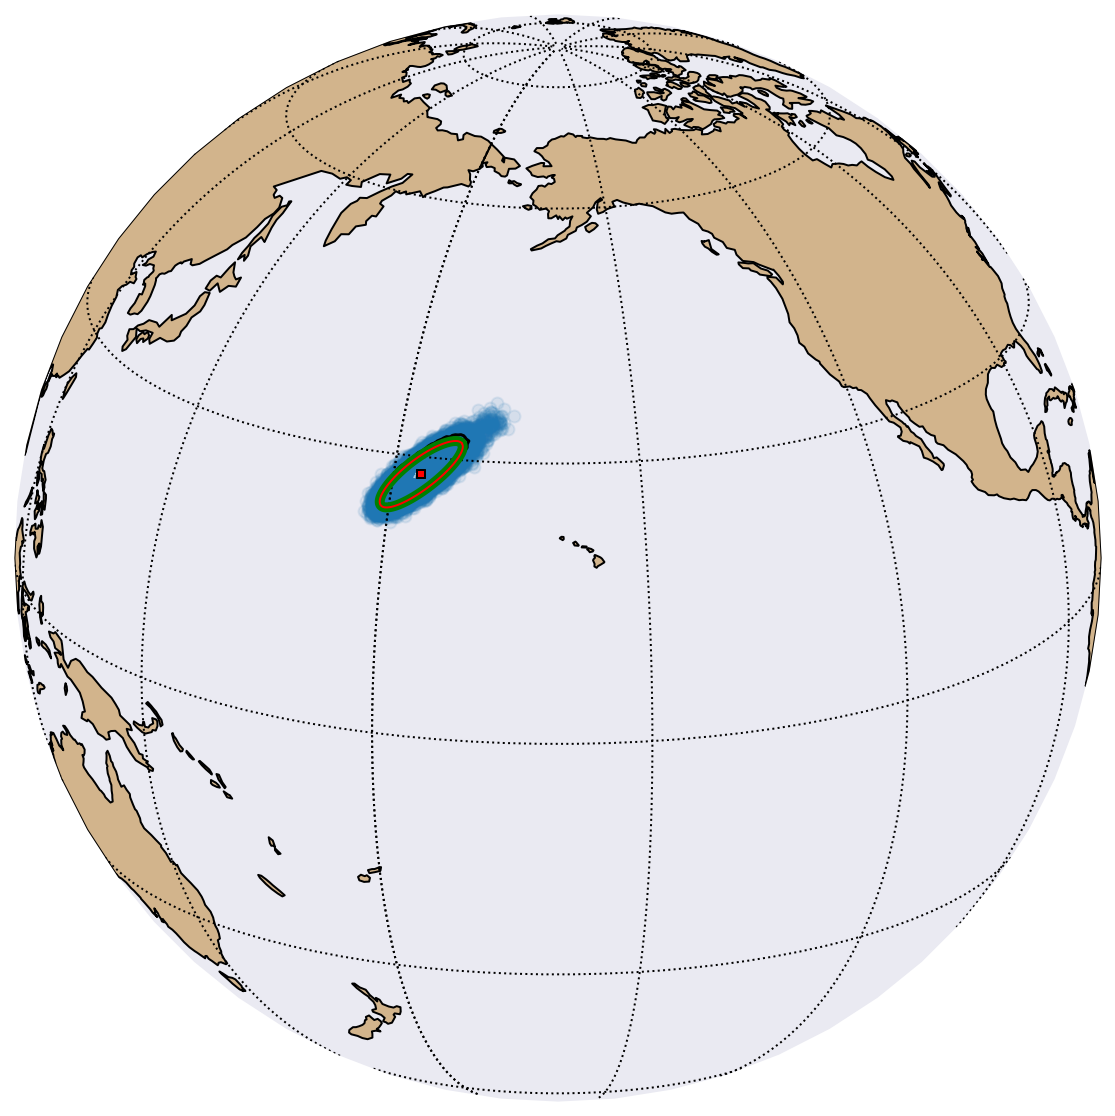

In [55]:
# plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20, figsize=(10,10))
# ipmag.plot_pole(m,188,28,2.5,label='Schroeder Lutsen Basalts', marker='s',color='Blue')
# ipmag.plot_pole(m,182,31,4.2,label='North Shore Volcanic Group (upper NE)',marker='s',color='Red')
plot_distributions(m, kent_lons, kent_lats, to_plot='s', resolution = 500)
# plot_distributions(m, kent_lons, kent_lats, to_plot='d', resolution = 500, cmap='Reds')
plot_distributions(m, kent_lons, kent_lats, to_plot='e', resolution = 500, cmap='Greys', lw=10)
plot_pole_ellipse(m, kent_fits_modified, color='green', lw=5)
plot_pole_ellipse(m, kent_fits_95, color='red', lw=1)


# m.legend()